# Camera calibration

The first thing to do is to calibrate the camera using the chessboard images taken from the same camera. The way this calibration is done is by finding on all images the position of the chessboard corners using the OpenCV function [findChessboardCorners(...)](http://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#cv2.findChessboardCorners) and to match these image points with the 3D physical position of the chessboard corner. The two array (corners positions in images and in the physical point) are then given to the [calibrateCamera(...)](http://docs.opencv.org/2.4.1/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#calibratecamera) function which return the camera distortion parameters.

## Step one: Identify the chessboard corners
The first step is to iterate throught the images to find the chessboard corners, and populate two arrays containing the image and physical points.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

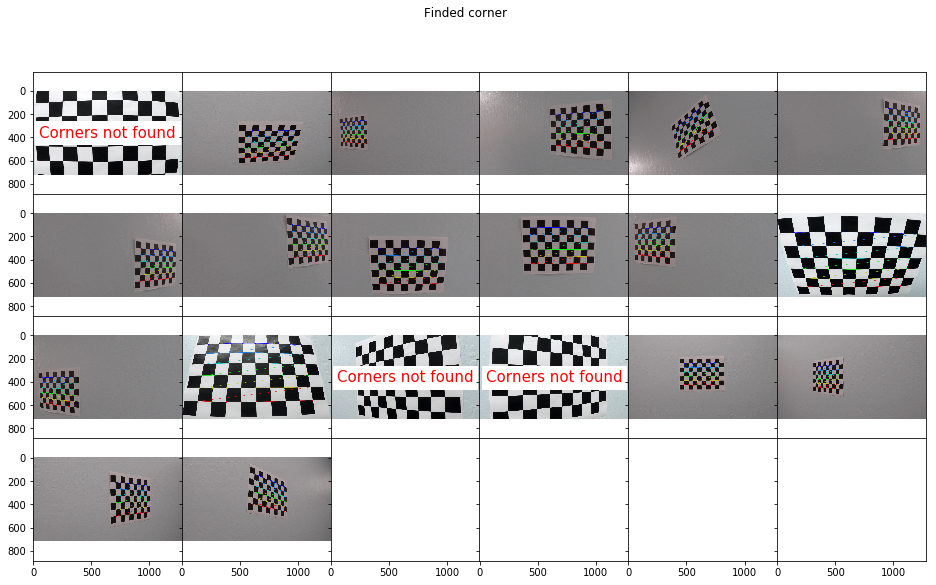

In [2]:
# chessboard number of corners
nx,ny = 9,6

# object points, from (0,0,0), (1,0,0), to (8,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points
objpoints = [] # 3d physical points
imgpoints = [] # 2d image points

# All images
images = glob.glob('camera_cal/calibration*.jpg')

# plot images on grid
f, axs = plt.subplots(4, 6, sharex='col', sharey='row', figsize=(16,9))
f.suptitle('Finded corner')
f.subplots_adjust(hspace=0.,wspace=0.)
axs[0,0].set_xlim([0, 1280])
axs[0,0].set_ylim([720,0])


# helper function
get_ax = lambda idx: axs[idx//6, idx%6]

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # get the corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny))

    # add object and image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        get_ax(idx).imshow(img)
    else:
        get_ax(idx).imshow(img)
        get_ax(idx).text(.5,.5, 'Corners not found',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=15, color='red',
        backgroundcolor='white',
        transform=get_ax(idx).transAxes)


We can see that for three images, the corners are not found. This is due to the fact that some of these corners are outside the picture (or at the very edge of it). It's not a big problem, as we still have 17 pictures where we correctly identify the full chessboard, which is enough to calibrate our camera.

## Step 2: Get the camera calibration parameters
This step is easily done by using OpenCV library function

In [3]:
# use last picture to get the shape
img_size = img.shape[0:2]
img_size = img_size[::-1]

# Do camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)


In [4]:
import pickle
# save the calibration parameters as a checkpoint
calib_pickle = {
    'ret': ret,
    'mtx': mtx,
    'dist': dist,
    'rvecs': rvecs,
    'tvecs': tvecs
}
pickle.dump(calib_pickle, open("calibration.p", "wb"))

In [5]:
# restore saved data from checkpoint
try:
    calib
except NameError:
    calib = pickle.load(open( "calibration.p", "rb" ))


## Step 3: Verify the undistortion on calibration images
To be sure that the calibration went correctly, here are a few undistored examples

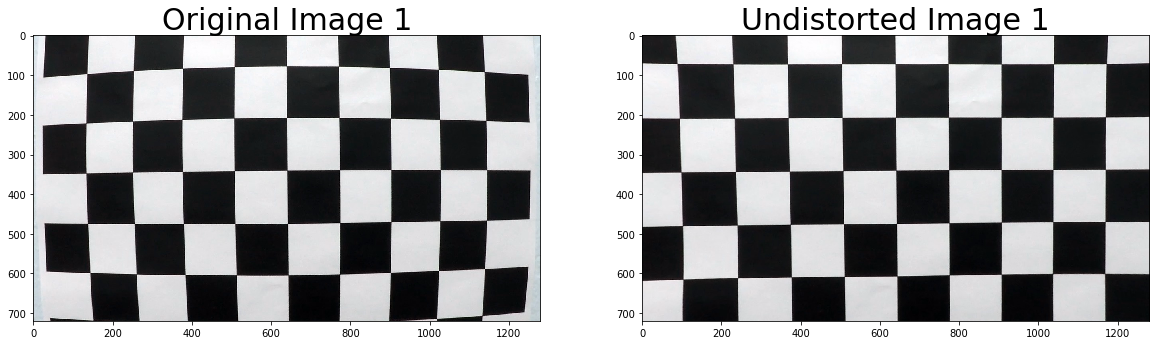

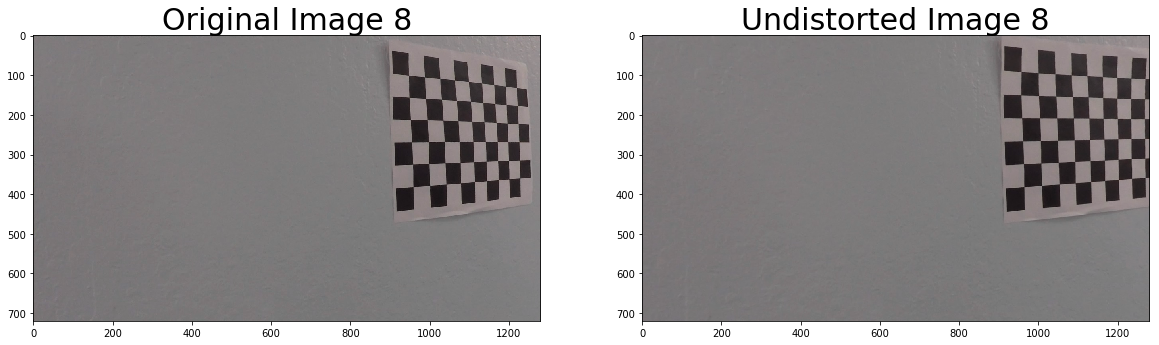

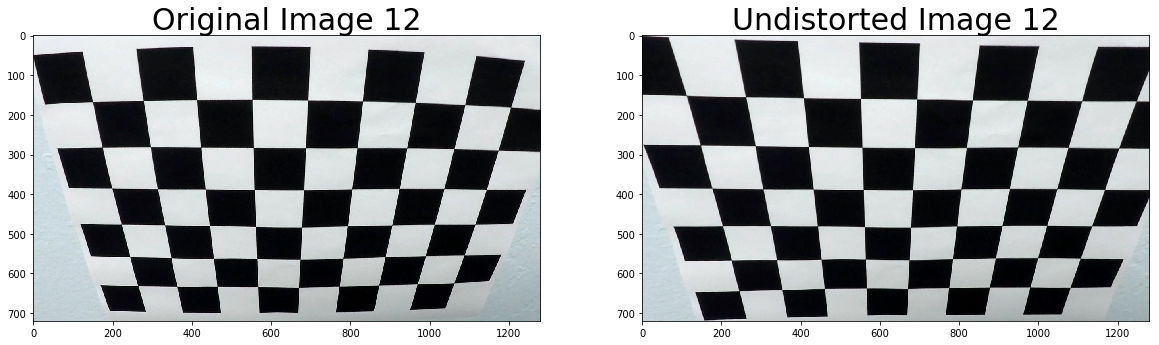

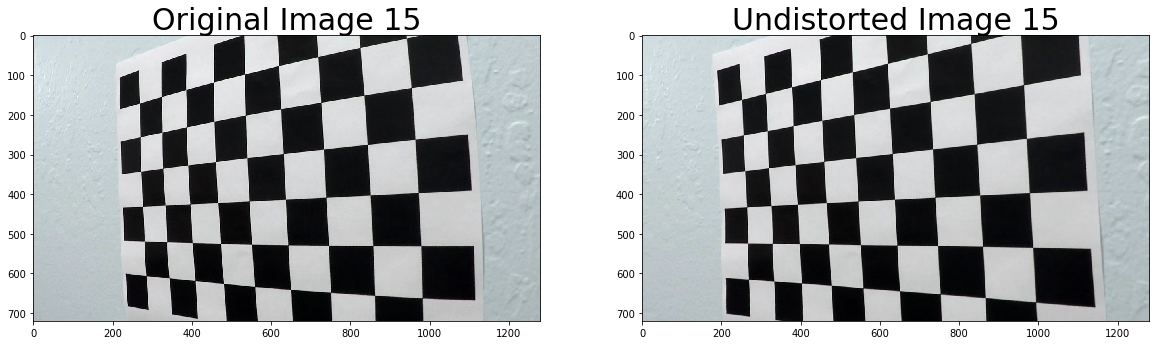

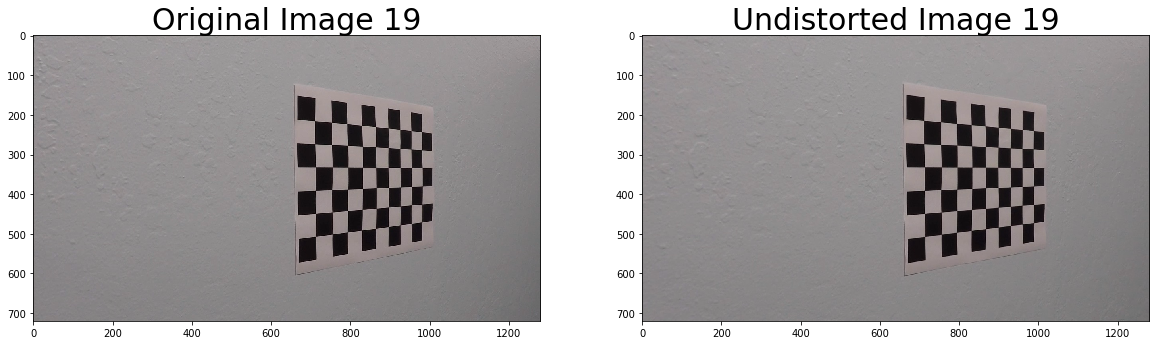

In [6]:
# display only some images, no need for all
undistord_idx = [0,7,11,14,18]

for idx in undistord_idx:
    fname = images[idx]
    img = cv2.imread(fname)
    
    #undistord the image
    dst = cv2.undistort(img, calib['mtx'], calib['dist'], None, calib['mtx'])
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image {}'.format(idx+1), fontsize=30)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image {}'.format(idx+1), fontsize=30)

# Line finding pipeline
The line finding pipeline (for a single image) will be as follow:

1. Undistord the image using pre-calculated camera parameters
2. Create a thresholded binary image (using gradient, color space transformation, ...)
3. Transform the perspective to have a bird-eye view
4. Identify lane pixel and fit a polynomial
5. Compute the radius of curvature and the position of the vehicle in the lane
6. Include all these information as an overlay in the original (undistored) image


## Function for each step of the pipeline

### Step 1: Undistord the image
Simply apply the OpenCV function. The difference isn't as visible on real world image as it is on chessboard.

In [7]:
def undistord(img, calib):
    return cv2.undistort(img, calib['mtx'], calib['dist'], None, calib['mtx'])

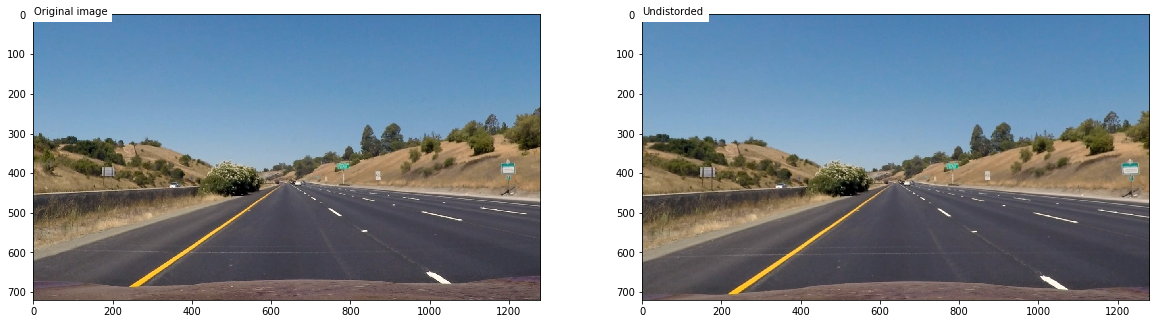

In [8]:
test_images = glob.glob('test_images/*.jpg')

img = plt.imread(test_images[0])
undist = undistord(img, calib)

f = plt.figure(figsize=(20,10))
ax1=f.add_subplot(1, 2, 1)
ax1.imshow(img)
plt.text(1,1,'Original image', color='k',backgroundcolor='w')
ax2=f.add_subplot(1,2,2)
ax2.imshow(undist, vmin=0, vmax=1)
plt.text(1,1,'Undistorded', color='k',backgroundcolor='w')

### Step 2: Create thresholded binary image
I detect marking line using a sobel derivative in the X direction and by looking at the saturation threshold of the image in hls space. Then I combine the pixels founded by these two methods together, to have pixels which could be part of the ground marking. There are also pixels not part of these lines, but they will be rejected by the following parts of the pipeline (for example if they are outside of the region of interest, they will not be on the image after perspective transformation)

In [9]:
def create_binary(img, s_thresh=(170, 220), sx_thresh=(45, 100)):
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    binary = np.zeros_like(s_channel)
    binary[(s_binary == 1)] = 1
    binary[(sxbinary == 1)] = 1
    return binary

Example on one of the test pictures

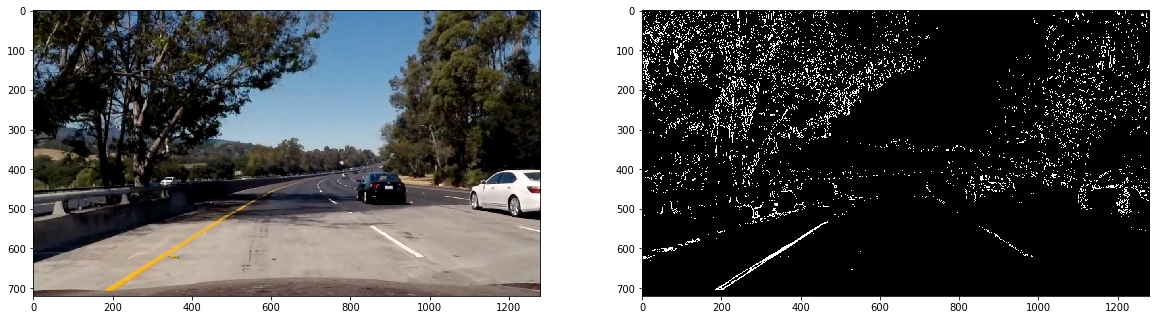

In [10]:
fname = test_images[6]
#fname = "/home/nicolas/vlcsnap-2017-04-14-11h56m20s766.jpg"
img = cv2.imread(fname)
img = undistord(img, calib)
    
binary = create_binary(img)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax2.imshow(binary, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)

### Step 3: Perspective transformation
The goal of the perspective transformation is to map the original image to a new image which would look like a picture taken from "above" the road, with parallel straight lines in the physical world seen as parallel straight lines on the new picture, instead of lines converging to the vanishing point.

The points used as source must be identified in the original picture as forming a rectangle, and the destination points must form a real rectangle in the new picture. (In my case, I have "stolen" the values from the example in the udacity github repository)

In [11]:
def transform_perspective(img, reverse=False):
    # transformation points
    src = np.float32([[585, 460], [203, 720], [1127, 720], [695, 460]])
    dst = np.float32([[320, 0],   [320, 720], [960, 720],  [960, 0]])
    
    # get the transformation matrix
    if not reverse:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst,src)
    # Maybe TODO: possible improvement: cache this matrix
    
    # transform the image
    img_size = img.shape[0:2]
    warped = cv2.warpPerspective(img, M, img_size[::-1], flags=cv2.INTER_LINEAR)

    return warped

Test of the perspective tranformation on image of the test set. I have added a red contour showing the selected points for the transformation.

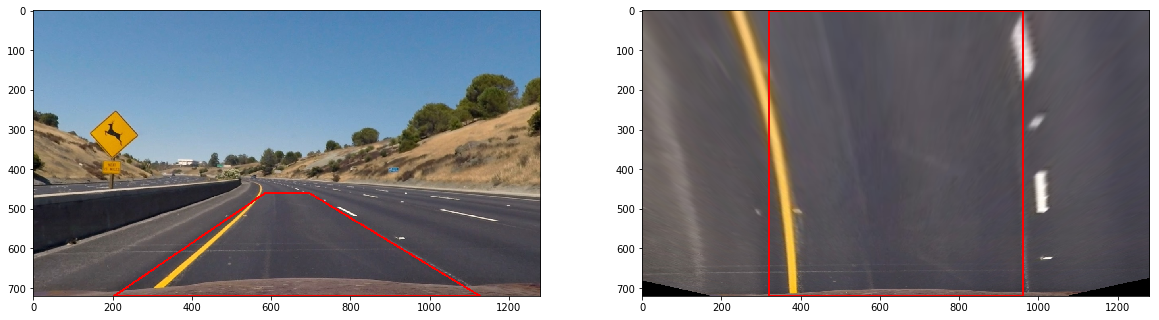

In [12]:
# Example of perspective transformation
fname = test_images[3]
#fname = "/home/nicolas/vlcsnap-2017-04-14-11h49m07s94.jpg"
img = cv2.imread(fname)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = undistord(img, calib)
    
top_down = transform_perspective(img)

# add the points used for the transform
src_points = [(585, 460), (203, 720), (1127, 720), (695, 460)]
dst_points = [(320, 1),   (320, 720), (960, 720),  (960, 1)]   # replaced 0 by 1 to see it in the picture
for i in range(4):
    img = cv2.line(img, src_points[i], src_points[(i+1)%4], (255,0,0), 3)
    top_down = cv2.line(top_down, dst_points[i], dst_points[(i+1)%4], (255,0,0), 3)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax2.imshow(top_down)

### Step 4: Find line and fit polynomial
To find the lines, I compute an histogram of the binary wrapped image, column by column, on the bottom part of the image. Then I identify the peak of the histogram, that should be arround the starting point of the left and right line. Then starting from the bottom, "scroll up" throught the image (divided in several group of horizontal strip) and find the line points.

In [13]:
def find_lines(img):
    # Take a histogram of the bottom half of the images
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    
    # image for debugging purpose, to be removed
    out_img = np.dstack((img, img, img))*255
    
    # left/right peak of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    if hasattr(find_lines, 'seed') and midpoint < find_lines.seed[0] < histogram.shape[0] and max(histogram[midpoint:]) <25:
        rightx_base = int(find_lines.seed[0])
    if hasattr(find_lines, 'seed') and 0 < find_lines.seed[1] < midpoint and max(histogram[:midpoint]) < 25:
        leftx_base = int(find_lines.seed[1])

    nwindows = 9
    window_height = np.int(img.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    empty_win_l = empty_win_r = 0
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds)<5:
            empty_win_l+=1
        if len(good_right_inds)<5:
            empty_win_r+=1
            
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    points_l = [[x,y] for x,y in zip(leftx, lefty)]
    points_r = [[x,y] for x,y in zip(rightx, righty)]

    return np.array(points_l), np.array(points_r), empty_win_l<4, empty_win_r<4

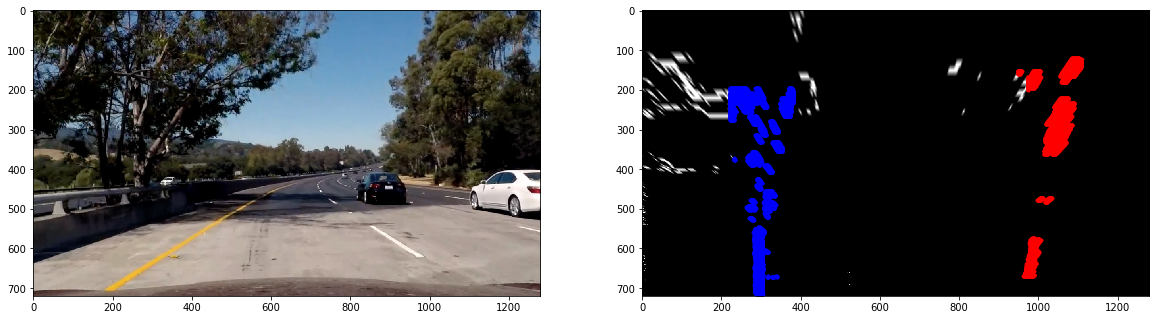

In [14]:
fname = test_images[6]
#fname = "/home/nicolas/vlcsnap-2017-04-14-11h56m20s766.jpg"

img = cv2.imread(fname)
img = undistord(img, calib)
    
binary = create_binary(img)

top_down = transform_perspective(binary)

points_l,points_r, ok_l, ok_r = find_lines(top_down)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax2.imshow(top_down, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
ax2.plot(points_l[:,0], points_l[:,1], 'b.')
ax2.plot(points_r[:,0], points_r[:,1], 'r.')

Get the best fit polynom coefficients for $x = f(y) = A y^2 + B y + C$. This is done as $x = f(y)$ and not $y = f(x)$ as we are looking for "vertical" functions, so we may have multiple y values for a single x, which cannot be described by $y = f(x)$

Also I did transform the coordinates unit here from pixel to meters (using pixel to meter conversion given in class)

In [15]:
def fit_poly(points, deg=2, side='right', ok=True):
    '''Return the polynomial coefficients both in pixel and meters'''
    # Transform from pixel to meters
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700
    
    max_cov = .3
    
    # numpy x and y are swapped as we want to fit x = f(y) and not the opposite
    if side=='left':
        if len(points)>3000 and ok:
            poly,V = np.polyfit(points[:,1], points[:,0], deg, cov=True)
            if np.mean(V)<max_cov:
                fit_poly.poly_px_l = poly
                fit_poly.poly_meter_l = np.polyfit(points[:,1]*ym_per_pix, points[:,0]*xm_per_pix, deg)
        return fit_poly.poly_px_l, fit_poly.poly_meter_l
    else:
        if len(points)>3000 and ok:
            poly,V = np.polyfit(points[:,1], points[:,0], deg, cov=True)
            if np.mean(V)<max_cov:
                fit_poly.poly_px_r = poly
                fit_poly.poly_meter_r = np.polyfit(points[:,1]*ym_per_pix, points[:,0]*xm_per_pix, deg)
        return fit_poly.poly_px_r, fit_poly.poly_meter_r

### Step 5: Curvature and position
The curvature is computed for both the left and right polynom fit using the formula $\frac{(1+(2Ay+B)^2)^3/2}{|2A|}$. The resulting radius of curvature is the mean of these two values

In [16]:
def curvature(coeffs_left, coeffs_right):
    curve = lambda c: ((1 + (2*c[0]*720 + c[1])**2)**1.5) / np.absolute(2*c[0])
    l_curve = curve(coeffs_left)
    r_curve = curve(coeffs_right)
    
    # transform from pixel to m
    return (l_curve + r_curve)/2

The position on the lane is computing by taking the intersection for the fitted polynom for left and right with the bottom of the picture. The center of these two intersections is the center of the lane. The delta between the center of the lane and the center of the image is multiplied by a scale factor based on the width of the lane (3.7 is assumed, I compute the width of the lane in pixel using the two intersections. The camera is assumed to be in the center of the car)

In [17]:
def position(coeffs_left, coeffs_right):
    intersect = lambda coeffs: coeffs[0]*720**2 + coeffs[1] * 720 + coeffs[2]
    x_left = intersect(coeffs_left)
    x_right = intersect(coeffs_right)
    
    lane_center = (x_left+x_right)/2
    lane_width = x_right-x_left
    
    # the center position in this space (birds-eye) is not located at 1280/2, but slightly offset
    # compute the center value from datapoints of the birds-eye wrapping
    center = (640-203)/(1127-203)*640+320
    delta = (lane_center - center)/lane_width*3.7
    
    return delta

### Step 6: Create overlay image
Use all computed informations to overlay the computed data on the picture. The following elements are added:

- the lane is painted in green using the left and right polynoms as border
- the center of the lane is painted in white over the green overlay
- the left and right line points are painted in red and blue
- the curvature and delta from the center line are added as text

In [18]:
def create_overlay(img, points_left, points_right, coeffs_left_px, coeffs_right_px, curvature, position):
    
    overlay = np.zeros_like(img)
    
    # draw the detected lane
    xl = []
    xr = []
    center = []
    
    poly = lambda y,coeff: coeff[0]*y**2 + coeff[1]*y + coeff[2]
    for yy in range(0,721,10):
        l = poly(yy,coeffs_left_px)
        r = poly(yy,coeffs_right_px)
        xl.append([l, yy])
        xr.append([r, yy])
        center.append([(l+r)/2, yy])
        
    # set the seed for the find_lines function next image
    find_lines.seed = [xr[0][0], xl[0][0]]
    
    pts = np.int32([np.array(xl + xr[::-1])])
    center = np.int32([np.array(center)])
    
    cv2.fillPoly(overlay, pts, (0,255,0))
    
    cv2.polylines(overlay, center, False, (255,255,255), 10)
    
    # identify all points finded for lines
    for p in points_left:
        cv2.circle(overlay,tuple(p), 2, (255,0,0), -1)
    for p in points_right:
        cv2.circle(overlay,tuple(p), 2, (0,0,255), -1)
        
    unwrapped = transform_perspective(overlay, reverse=True)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    alpha=0.8
    final = cv2.addWeighted(unwrapped, alpha, img, 1, 0)
    
    radius_string = 'Radius of curvature: {:6d}m'.format(int(curvature))
    pos_string = 'The car is {:2.2f}m {} of the center'.format(abs(position), 'left ' if position>0 else 'right')
    
    cv2.putText(final,radius_string,(100,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(final,pos_string,(100,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    return final

## Create the pipeline
Assemble the 6 step above to get the full pipeline

In [19]:
def image_pipeline(img, calib):
    # undistord the image
    undis = undistord(img, calib)
    
    # binary thresholded image
    binary = create_binary(undis)
    
    # birds-eye view
    top_down = transform_perspective(binary)
    
    # find points of the lines
    points_left,points_right, ok_l, ok_r = find_lines(top_down)
    
    # fit polynome
    coeff_left_px, coeff_left = fit_poly(points_left, side='left', ok=ok_l)
    coeff_right_px, coeff_right = fit_poly(points_right, side='right', ok=ok_r)
    
    # get the road curvature
    radius = curvature(coeff_left, coeff_right)
    
    # get the car position
    pos = position(coeff_left_px, coeff_right_px)
    
    # assemble everything on the image
    overlay = create_overlay(img, points_left, points_right, coeff_left_px, coeff_right_px, radius, pos)
    
    return overlay, radius, position

## Apply the pipeline to the test images

Note: The white line is the center of the lane.

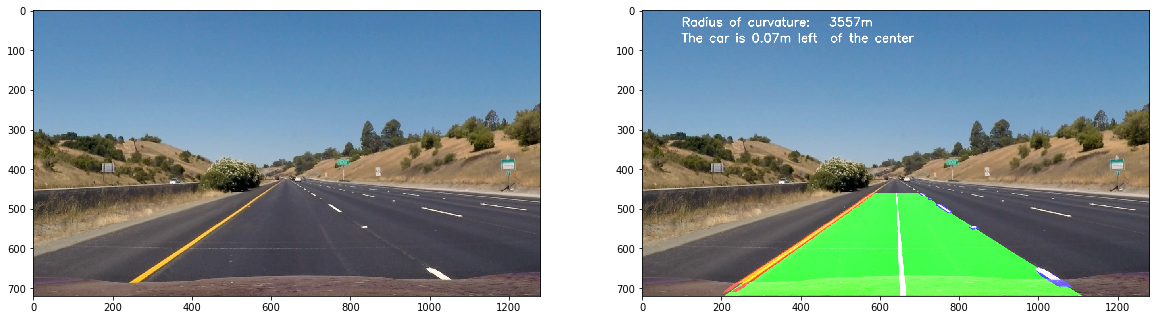

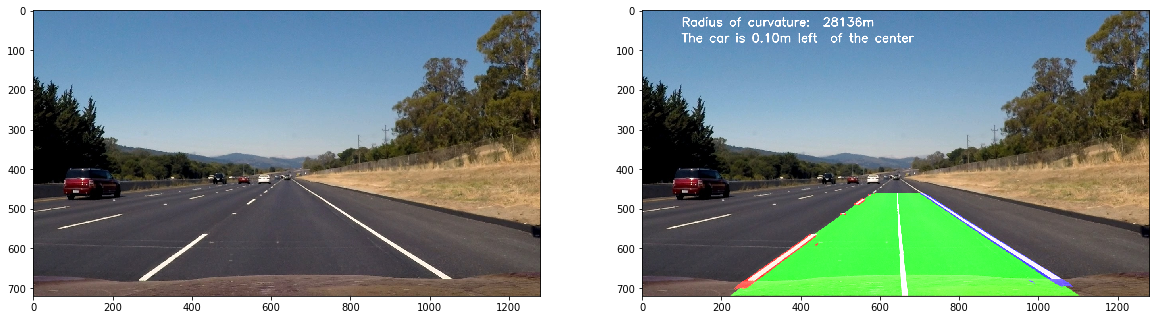

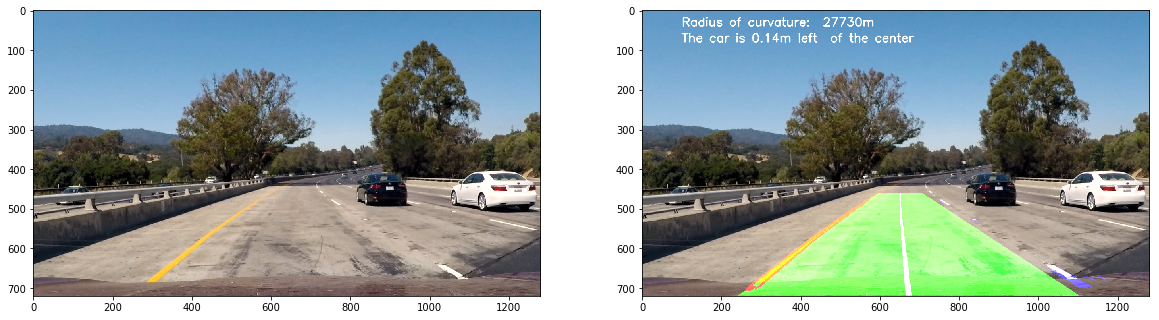

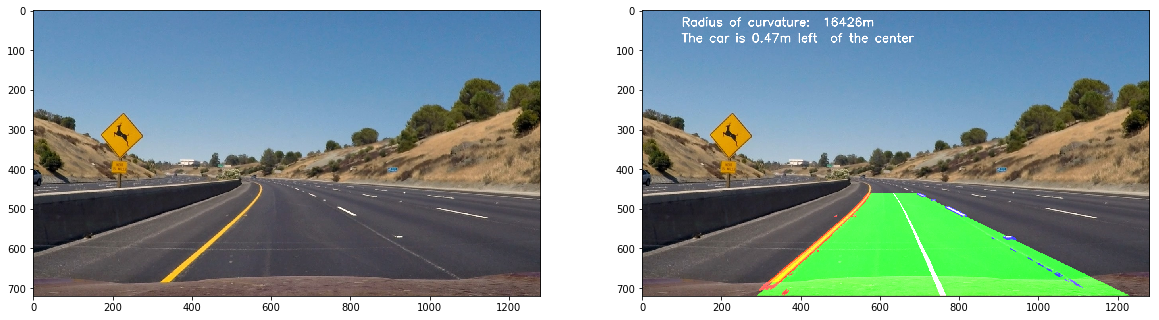

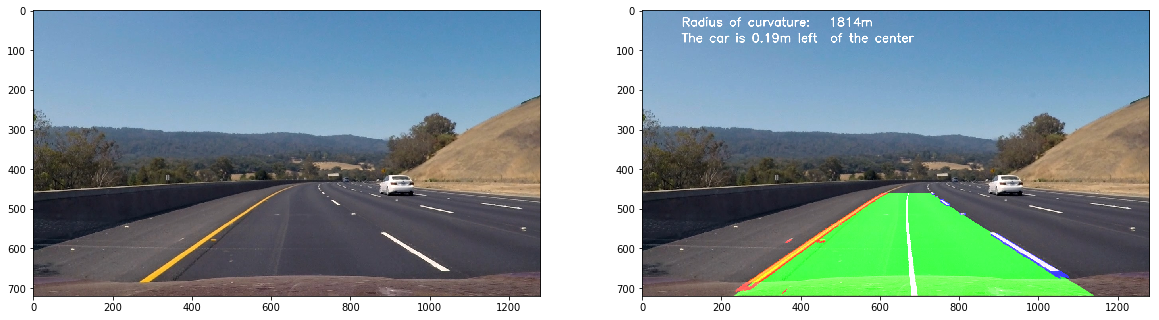

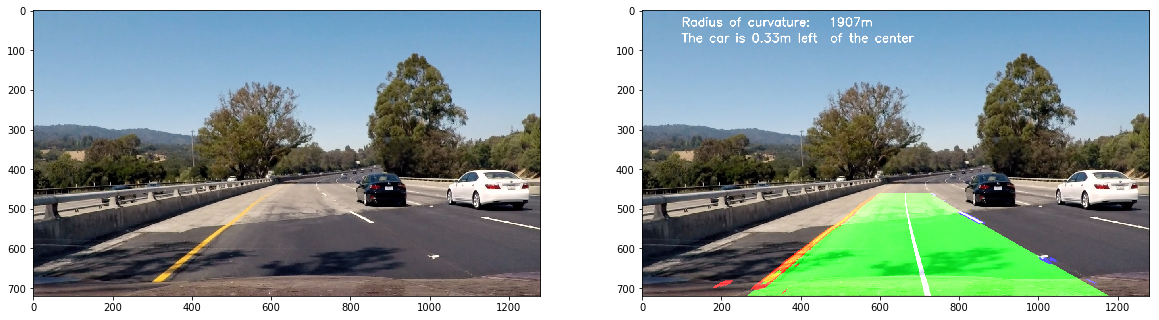

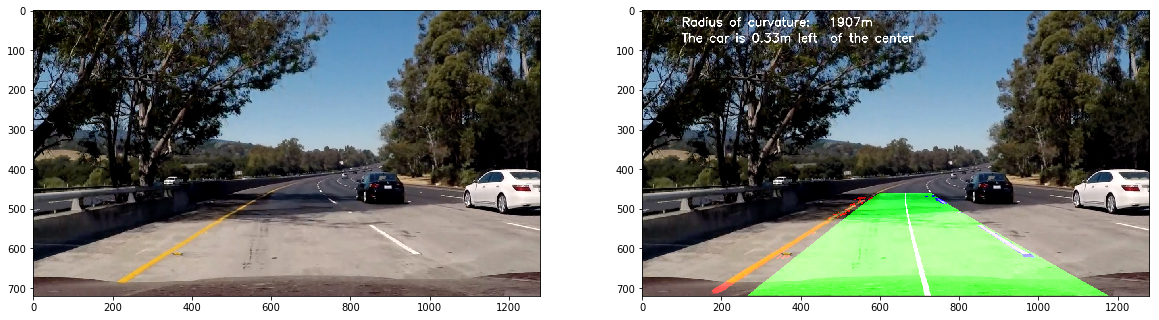

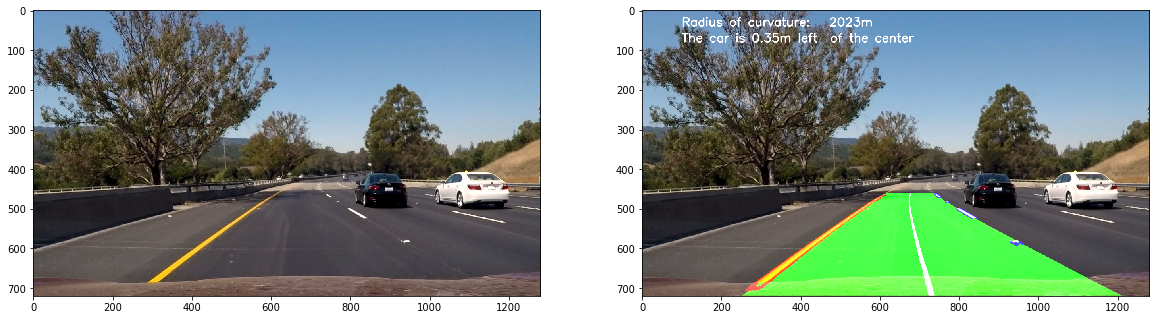

In [20]:
for fname in test_images:
    img = cv2.imread(fname)
    overlayed, radius, position = image_pipeline(img, calib)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax2.imshow(overlayed)


# Video pipeline
The video pipeline is simply the image pipeline repeated, with a few additions. I have added a few checks on the data identified on one image, and if it seems not good, I reuse previous image data.

The conditions that trigger the reuse of the previous data:
- when looking for the max in the histogram, if the max value is low, I will look for lines starting around the same position than in the previous image, instead of using the histogram max position
- when fitting a polynom throught the identified points, if the variance of coefficients is high, discard this polynom and use the previous good one
- if there is not enough points found when looking for line marking, keep the previous polynom
- when looking for points, the picture is divided in 9 windows (vertically). If there is no points in more than 5 out of 9 windows, keep using the previous polynom. (this makes the algorithm robust in a few case were he find the line only at the top or only at the bottom of the picture)

In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

try:
    delattr(find_lines, "seed")
except:
    pass
def process_image(image):
    img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    im,x,y = image_pipeline(img, calib)
    return im

video = 'project_video_out.mp4'
clip = VideoFileClip('project_video.mp4', audio=False)
#clip = VideoFileClip('cut5.mp4', audio=False)
video_clip = clip.fl_image(process_image)
%time video_clip.write_videofile(video, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [08:56<00:00,  2.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 16min 52s, sys: 6min 3s, total: 22min 56s
Wall time: 8min 58s


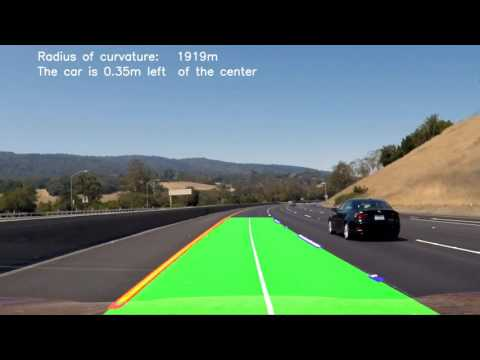

In [23]:
from IPython.display import YouTubeVideo
YouTubeVideo('myRTGzqY0Lc')

# Conclusion

The video pipeline developed in this project did a fairly good job of detecting the lane lines in the test video provided for the project, which shows a road in basically ideal conditions. But at some points, it detect the central wall instead of the left yellow lane.

A possible improvement that I have to add would be to average the coefficients over several frames of the video, to filter out noise that could happen spuriously.

On the challenge video given with the project, the detection works well in the "easy" parts of the video, that is the part with not too much curvature and a relatively constant brightness, but it has problem when there are shadows on part of the images. This problem could be diminished by normalizing the local and global brightness of the image.

Another easy improvement which would only improve the speed of the pipeline and not the accuracy would be to only apply the sobel derivative on the region of interest of the image.